In diesem Notebook machen wir eine Sozialstrukturanalyse, d.h. wir untersuchen die Stadtbezirke Münsters hinsichtlich der sozialen Bevölkerungsstruktur (anhand von Sozialindikatoren). Die zu analysierende Datei "05515000_csv_indikatoren_sozial.csv" enthält Prozentanzahl-Angaben von Merkmalen wie zB "Anteil Arbeitslose" etc in den Stadtbezirken.

In [307]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd # für die Verarbeitung der Geodaten
from IPython.display import Image, display
from PIL import Image as PILImage
import requests
from io import BytesIO
#!pip install PyMuPDF
import fitz


#Quelle https://opendata.stadt-muenster.de/dataset/bev%C3%B6lkerungsindikatoren-soziales Jahre 2014-2022

df=pd.read_csv("https://raw.githubusercontent.com/SabGe90/techlabs24/f52b80b9801f35198bd5fc69a652a991237ba6ff/Dateien/05515000_csv_indikatoren_sozial.csv",  encoding='unicode_escape', sep=";") #encoding='unicode_escape' sonst unicode-decode error

#general info
df.head()

,ZEIT,RAUM,MERKMAL,WERT
0,2017,91 Berg Fidel,Anteil der männlichen Kinder mit Migrationsvor...,76.86
1,2017,91 Berg Fidel,Anteil der Kinder mit Migrationsvorgeschichte ...,76.63
2,2017,91 Berg Fidel,Anteil der weiblichen Kinder mit Migrationsvor...,76.36
3,2022,91 Berg Fidel,Anteil der männlichen Kinder mit Migrationsvor...,74.96
4,2018,91 Berg Fidel,Anteil der männlichen Kinder mit Migrationsvor...,74.27


In [308]:

df.describe(exclude=np.number) #descriptive statistics non-numeric values
print(df.describe()) #descriptive statistics numeric values

print('Wir sehen dass die Datenquelle Informationen von der Jahresspanne 2014-2022 beinhaltet.')
print('')
print('')

df.info()
df['WERT']=pd.to_numeric(df['WERT'])#astype can not convert string to float
df['ZEIT']=df['ZEIT'].astype('int64')

print('')
print('')

print('Alle Merkmale/Sozialindikatoren:')
print(df['MERKMAL'].unique())


              ZEIT         WERT
count  6084.000000  6066.000000
mean   2018.000000    15.276986
std       2.582201    14.786828
min    2014.000000     0.000000
25%    2016.000000     4.080000
50%    2018.000000     8.900000
75%    2020.000000    23.365000
max    2022.000000    76.860000
Wir sehen dass die Datenquelle Informationen von der Jahresspanne 2014-2022 beinhaltet.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6084 entries, 0 to 6083
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ZEIT     6084 non-null   int64  
 1   RAUM     6084 non-null   object 
 2   MERKMAL  6084 non-null   object 
 3   WERT     6066 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 190.2+ KB


Alle Merkmale/Sozialindikatoren:
['Anteil der männlichen Kinder mit Migrationsvorgeschichte an allen männlichen Kindern - Kernindikator 3'
 'Anteil der Kinder mit Migrationsvorgeschichte an allen Kindern - Kernindikator 3'

In [309]:
print("Bezirke mit der höchsten Summe aus Prozentzahlen, bezogen auf Sozialindikatoren (s.o.), für den Gesamtzeitraum 2014-2022:")
sum_WERT=df.groupby("RAUM")['WERT'].sum()
sum_WERT=sum_WERT.sort_values(ascending = False)
sum_WERT

Bezirke mit der höchsten Summe aus Prozentzahlen, bezogen auf Sozialindikatoren (s.o.), für den Gesamtzeitraum 2014-2022:


,WERT
RAUM,
61 Coerde,4076.59
91 Berg Fidel,3869.93
63 Kinderhaus-West,3333.36
6 Münster-Nord,3297.49
86 Angelmodde,2743.95
23 Bahnhof,2639.41
62 Kinderhaus-Ost,2379.05
81 Gremmendorf-West,2288.24
9 Münster-Hiltrup,2194.05


Geodaten vorbereiten und mit Sozialdaten verknüpfen:

In [310]:
# Kartendaten einlesen
map_df = gpd.read_file("https://raw.githubusercontent.com/SabGe90/techlabs24/f52b80b9801f35198bd5fc69a652a991237ba6ff/Dateien/stadtbezirk_und_teilbereich.shx",sep=';') # Stadtbezirke
map_detailed_df = gpd.read_file("https://raw.githubusercontent.com/SabGe90/techlabs24/f52b80b9801f35198bd5fc69a652a991237ba6ff/Dateien/stadtteil_(statistischer_bezirk).shx",sep=';') # Stadtteile

# jeweils die beiden Datensätze (Karten und Sozialdaten) anhand gemeinsamer Schlüssel zusammenfügen
merged_df = map_df.merge(sum_WERT, left_on=["STADTBEZIR"], right_on=["RAUM"]) # für die Stadtbezirke
merged_detailed_df = map_detailed_df.merge(sum_WERT, left_on=["STATIST_BE"], right_on=["RAUM"]) # für die Stadtteile (statistischen Bezirke)

Abbildung für Stadtbezirke erzeugen:

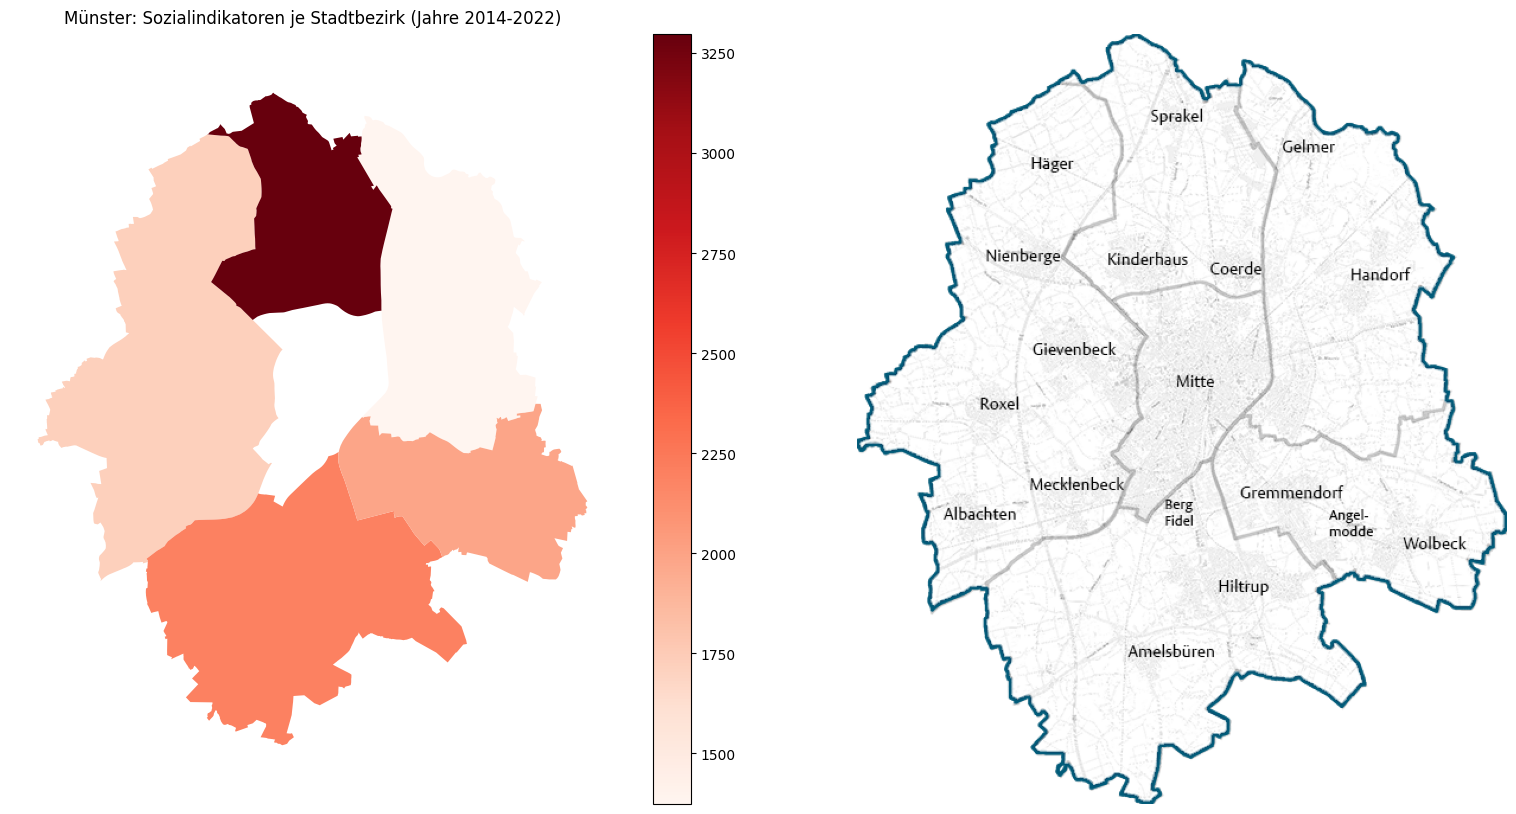

In [311]:
# Abbildung mit 2 Subplots (nebeneinander) erstellen:
fig, axs = plt.subplots(1, 2, figsize=(20, 10)) # 20 cm breit, 10 cm hoch

# 1. Subplot aus verknüpftem Datensatz erstellen:
merged_df.plot(column="WERT", cmap="Reds", legend=True, ax=axs[0])  # plotten
axs[0].set_title("Münster: Sozialindikatoren je Stadtbezirk (Jahre 2014-2022)", y=1.04) # Beschriftung vertikal etwas nach oben rücken
axs[0].axis("off")  # Achsen/Rahmen entfernen

# Karte von der Webseite der Stadt Münster laden
stadtteilkartemuenster = 'https://web.muenster.de/muenster_media/Stadtteilseiten/stadtteilkarte.png'
response = requests.get(stadtteilkartemuenster)
img = PILImage .open(BytesIO(response.content))

# Karte von der Webseite der Stadt Münster rechts im 2. subplot anzeigen:
axs[1].imshow(img)
axs[1].axis("off")  # Achsen/Rahmen entfernen

# Abstand in der Mitte zwischen den beiden Subplots vergrößern
plt.subplots_adjust(wspace=0.05)

# Gesamtplot anzeigen:
plt.show()



Abbildung für Stadtteile (statistische Bezirke) erzeugen:

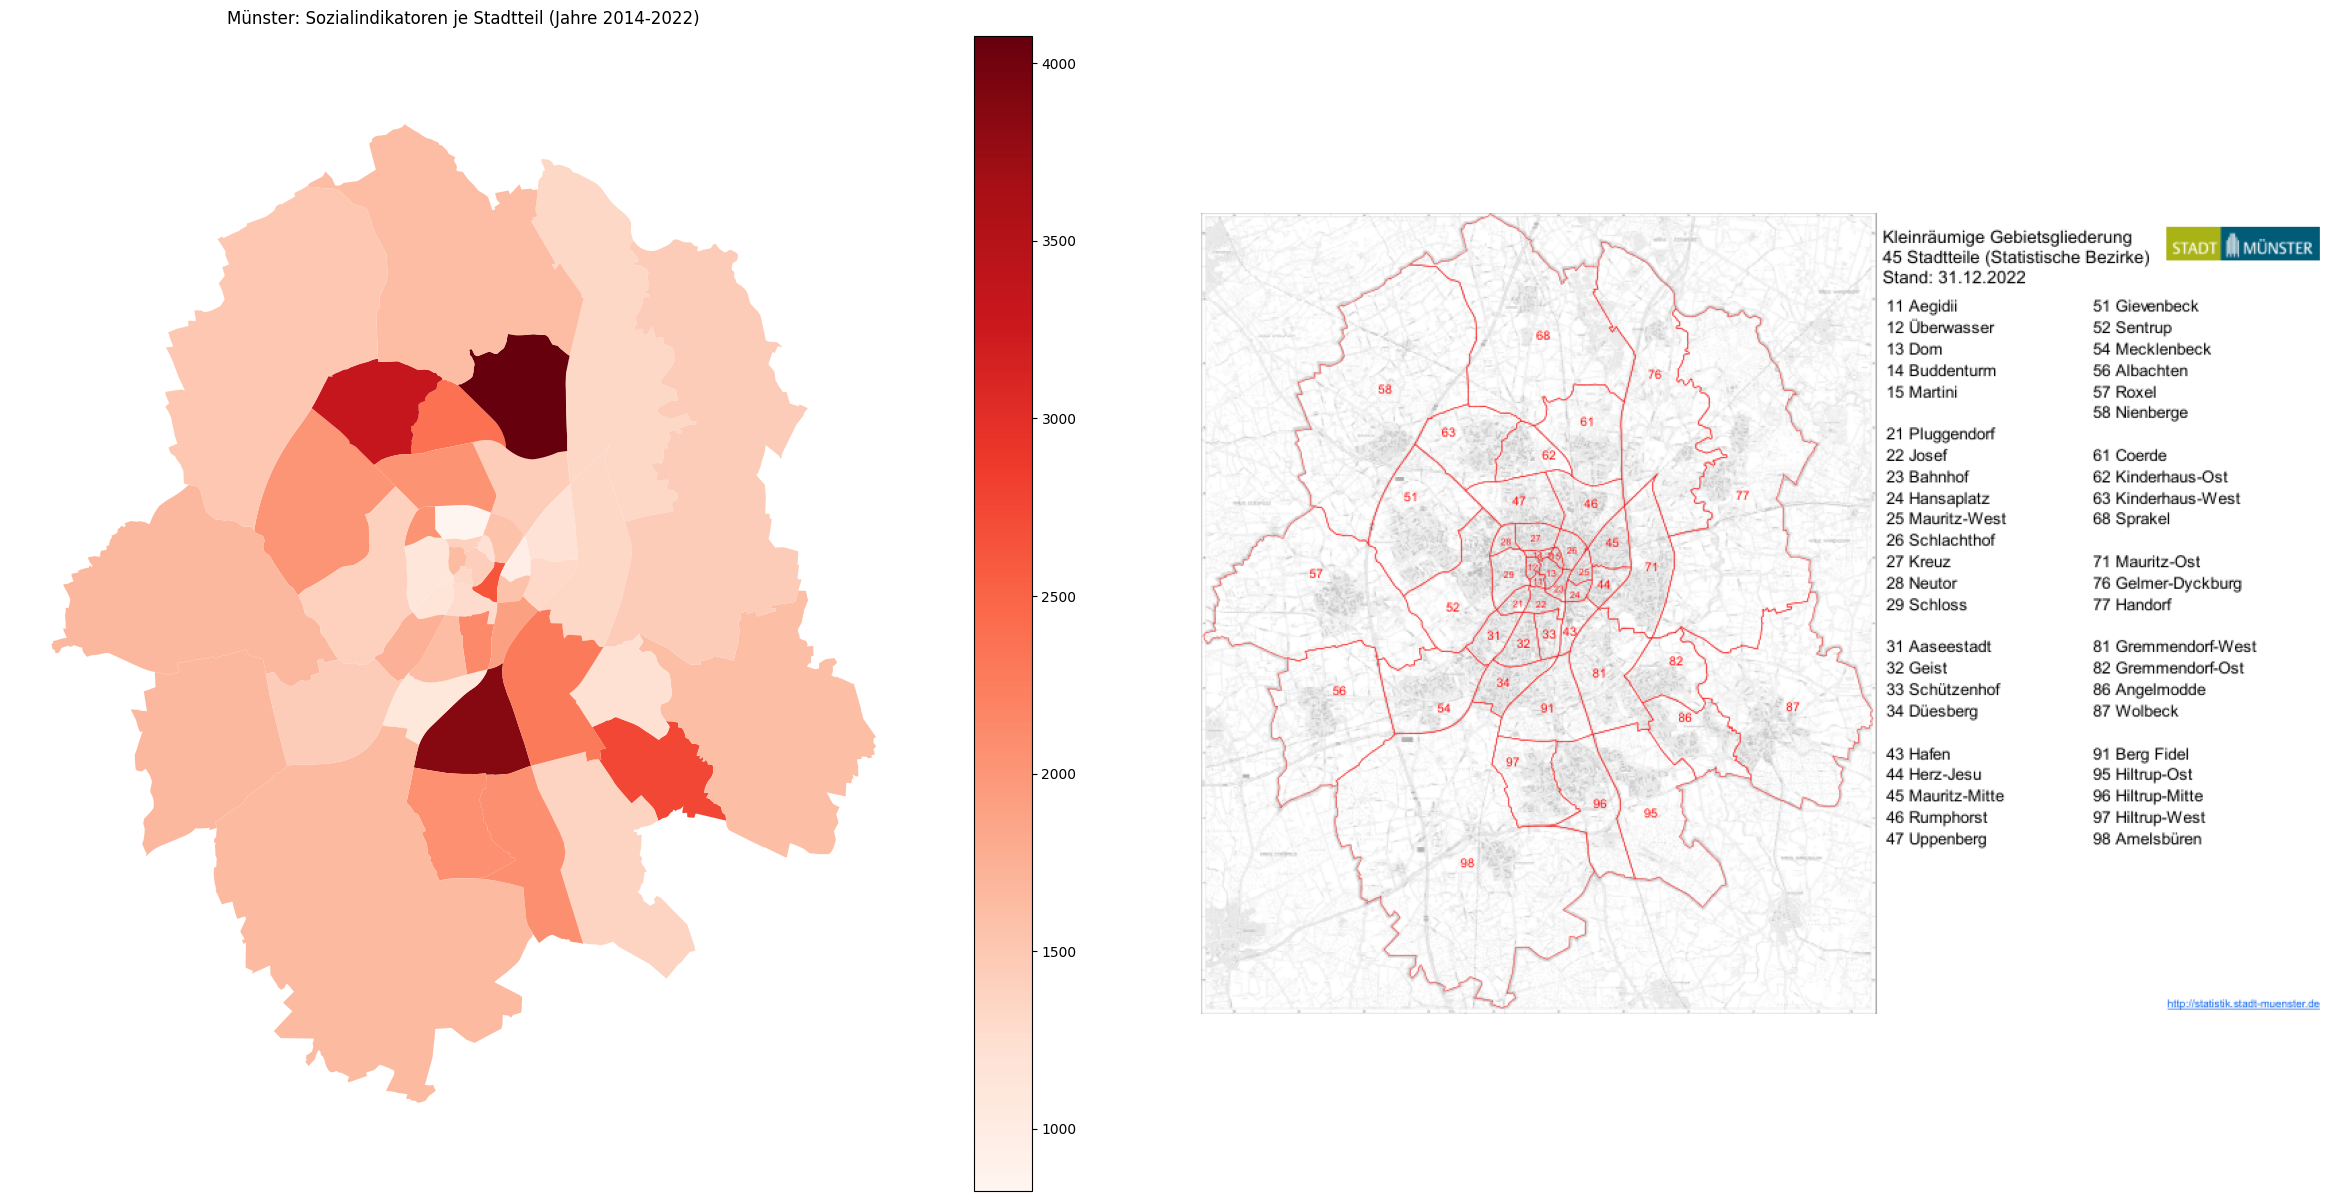

In [326]:
# Abbildung mit 2 Subplots (nebeneinander) erstellen:
fig, axs = plt.subplots(1, 2, figsize=(30, 15)) # 20 cm breit, 10 cm hoch

# 1. Subplot aus verknüpftem Datensatz erstellen:
merged_detailed_df.plot(column="WERT", cmap="Reds", legend=True, ax=axs[0])  # plotten
axs[0].set_title("Münster: Sozialindikatoren je Stadtteil (Jahre 2014-2022)", y=1.04) # Beschriftung vertikal etwas nach oben rücken
axs[0].axis("off")  # Achsen/Rahmen entfernen

# PDF-Karte von der Webseite der Stadt Münster laden
pdf_url = "https://www.stadt-muenster.de/fileadmin//user_upload/stadt-muenster/61_stadtentwicklung/pdf/karten/a3_stadtteil__statistischer_bezirk_.pdf"
response = requests.get(pdf_url)
pdf_document = fitz.open(stream=response.content)
page = pdf_document.load_page(0) # 1. Seite laden

# 1. Seite in Pixelmap umwandeln
pix = page.get_pixmap()
img = PILImage.open(io.BytesIO(pix.tobytes()))

# 1. PDF-Seite (Pixelmap) im 2. Subplot anzeigen
axs[1].imshow(img)
axs[1].axis("off")  # Achsen/Rahmen entfernen

# Abstand in der Mitte zwischen den beiden subplots vergrößern
plt.subplots_adjust(wspace=0.05)

# Gesamtplot anzeigen:
plt.show()

In [313]:
auffaellig=[sum_WERT.index[i] for i in range(0,6)]
auffaellig

['61 Coerde',
 '91 Berg Fidel',
 '63 Kinderhaus-West',
 '6 Münster-Nord',
 '86 Angelmodde',
 '23 Bahnhof']

Wir sehen dass der Datensatz ein Zeitintervall von 2014-2022 erfasst. Die Sozialindikatoren sind die Werte in df['MERKMAL'].unique(), dazu gehören Migrationshintergrund und Arbeitslosenquote. Die Stadtbezirke mit den höchsten Summen an Prozentzahlen haben wir in der Liste auffaellig gespeichert und sind Coerde, Berg Fidel, Kinderhaus-West, Münster-Nord, Angelmodde, Bahnhof. Und wie stark sich die Anteile von den Stadtbezirken mit den niedrigsten Summen (die Stadtbezirke mit dem "bestem sozialen Score") unterscheidet sieht man an folgendem Graphen:

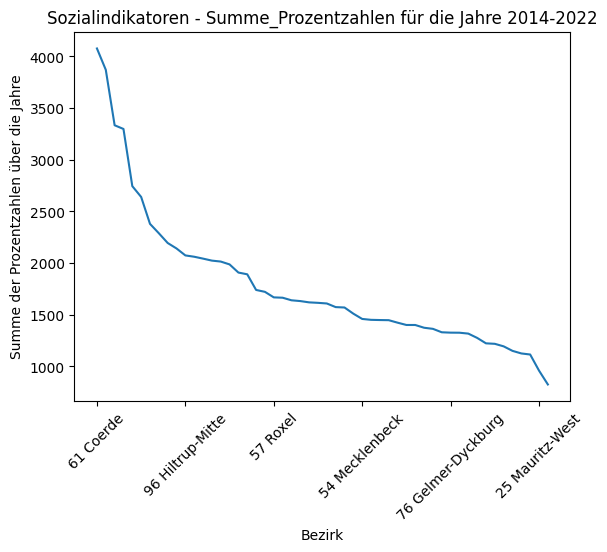



Coerde hat viel höhere Anteile an Migration, Arbeitslosigkeit etc, im Vergleich zu Gelmer-Dychburg oder Mauritz-West.


In [314]:
sum_WERT.plot().set(title="Sozialindikatoren - Summe_Prozentzahlen für die Jahre 2014-2022", xlabel="Bezirk", ylabel="Summe der Prozentzahlen über die Jahre")
plt.xticks(rotation=45)
plt.show()


print("")
print("")
print("Coerde hat viel höhere Anteile an Migration, Arbeitslosigkeit etc, im Vergleich zu Gelmer-Dychburg oder Mauritz-West.")

In [315]:
print("Höchsten Prozentsummen, nach Merkmal und Raum:")
sum_WERT=df.groupby(['MERKMAL','RAUM'])['WERT'].sum()
sum_WERT=sum_WERT.sort_values(ascending = False)
sum_WERT.head(20).unstack()

Höchsten Prozentsummen, nach Merkmal und Raum:


RAUM,91 Berg Fidel,61 Coerde,23 Bahnhof,63 Kinderhaus-West,6 Münster-Nord,86 Angelmodde,43 Hafen,81 Gremmendorf-West
MERKMAL,,,,,,,,
Anteil der männlichen Kinder mit Migrationsvorgeschichte an allen männlichen Kindern - Kernindikator 3,660.77,604.50,551.63,531.26,518.85,483.61,459.82,427.6
Anteil der Kinder mit Migrationsvorgeschichte an allen Kindern - Kernindikator 3,658.58,612.43,543.75,530.93,521.14,470.10,NaN,NaN
Anteil der weiblichen Kinder mit Migrationsvorgeschichte an allen weiblichen Kindern - Kernindikator 3,655.96,620.97,533.51,530.63,523.59,455.96,NaN,NaN


Wir sehen dass die Merkmale( Sozialindikatoren) auch nach Geschlecht aufgefächert sind, zB "Anteil der männlichen Kinder..." und "Anteil der weiblichen Kinder...", zusätzlich zum Gesamtanteil. Wir betrachten in Folgendem nur noch Gesamtanteile, und schließen datentechnisch die nach männlich und weiblich getrennten Anteile aus.

In [316]:
#Anteile generell, nicht nach männlich und weiblich getrennt
M1='Anteil der Kinder mit Migrationsvorgeschichte an allen Kindern - Kernindikator 3'
filt1=df['MERKMAL']==M1
df1=df[filt1]
M2='Anteil der SGBII-Personen im Alter von 0 - 14 Jahren an den Einwohnern im Alter von 0 - 14 Jahren - Kernindikator 2'
filt2=df['MERKMAL']==M2
df2=df[filt2]
M3='Anteil der Kinder in alleinerziehende Haushalten an allen Kindern in Haushalten - Kontextindikator 1'
filt3=df['MERKMAL']==M3
df3=df[filt3]
M4='Anteil der SGBII-Personen im Alter von 15 - 64 Jahren an den Einwohnern im Alter von 15 - 64 Jahren - Kernindikator 1'
filt4=df['MERKMAL']==M4
df4=df[filt4]
M5='Anteil der Arbeitslosen(SGB II UND SGB III) an der Wohnberechtigten Bevölkerung im Alter von 15 - 64 Jahren - Kontextindikator 2'
filt5=df['MERKMAL']==M5
df5=df[filt5]

Im Folgenden schauen wir uns die Merkmale im Einzelnen an für die Jahre 2014-2022 zusammen. Wir sehen dass die Stadtbezirke in der Liste "auffaellig" (Coerde, Berg Fidel, Kinderhaus-West, Angelmodde, Bahnhof, Münster-Nord) überall recht hohe Anteile haben, während das Kreuzviertel (Kreuz), Schloss und Mauritz-West immer niedrige Anteile haben.

<br>
<br>
<br>

**Bemerkung/Definition:**

**sum_WERT1 ist unsere Haupttabelle an der wir den sozialen Score auf Bezirk/Stadtteilebene festmachen. Die Stadtbezirke im obigen Bereich sind die Bezirke definieren wir als Bezirke mit niedrigem sozialen Index, und die im unteren Bereich der Tabelle als die Bezirke mit hohem sozialen Index.**
<br>Im Verlauf der Analyse/dieses Notebooks dröseln wir die Zahlen noch ein bisschen weiter auf.

In [317]:
#Anteil Migrationskinder, Summe der Prozente für die Jahre 2014-2022:
sum_WERT1=df1.groupby("RAUM")['WERT'].sum()
sum_WERT1=sum_WERT1.sort_values(ascending = False)
sum_WERT1

,WERT
RAUM,
91 Berg Fidel,658.58
61 Coerde,612.43
23 Bahnhof,543.75
63 Kinderhaus-West,530.93
6 Münster-Nord,521.14
86 Angelmodde,470.10
43 Hafen,420.88
33 Schützenhof,420.43
81 Gremmendorf-West,416.65


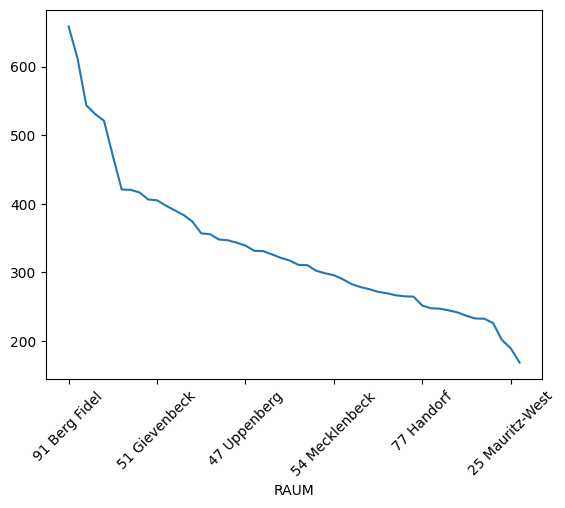

In [318]:
#Obige Ergebnisse geplottet:
sum_WERT1.plot()
plt.xticks(rotation=45)
plt.show()


RAUM
61 Coerde               377.11
91 Berg Fidel           314.83
63 Kinderhaus-West      293.19
6 Münster-Nord          291.59
86 Angelmodde           217.09
62 Kinderhaus-Ost       200.23
23 Bahnhof              193.55
28 Neutor               168.29
81 Gremmendorf-West     161.29
9 Münster-Hiltrup       159.65
96 Hiltrup-Mitte        159.48
47 Uppenberg            158.06
97 Hiltrup-West         143.84
8 Münster-Südost        139.06
51 Gievenbeck           135.48
Münster. Gesamtstadt    134.82
33 Schützenhof          133.27
32 Geist                127.28
43 Hafen                110.94
31 Aaseestadt           105.62
24 Hansaplatz           105.34
5 Münster-West          105.33
98 Amelsbüren           103.62
77 Handorf              101.73
87 Wolbeck               98.98
57 Roxel                 93.30
26 Schlachthof           91.92
52 Sentrup               90.35
13 Dom                   88.94
56 Albachten             88.02
58 Nienberge             87.52
7 Münster-Ost            86.30
1 M

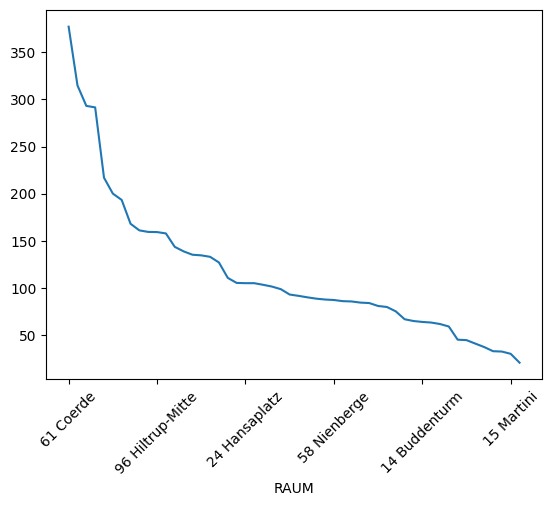

In [319]:
#Analog: Anteil SGBII-Personen im Alter von 0 - 14 Jahren
sum_WERT2=df2.groupby("RAUM")['WERT'].sum()
sum_WERT2=sum_WERT2.sort_values(ascending = False)
print(sum_WERT2)

sum_WERT2.plot()
plt.xticks(rotation=45)
plt.show()


RAUM
61 Coerde               270.87
96 Hiltrup-Mitte        231.11
6 Münster-Nord          223.87
91 Berg Fidel           223.53
32 Geist                222.86
24 Hansaplatz           219.12
33 Schützenhof          210.72
63 Kinderhaus-West      207.39
62 Kinderhaus-Ost       205.72
44 Herz-Jesu            187.07
47 Uppenberg            186.42
23 Bahnhof              185.28
28 Neutor               183.14
12 Überwasser           183.03
86 Angelmodde           182.21
81 Gremmendorf-West     181.56
15 Martini              181.39
22 Josef                178.87
31 Aaseestadt           177.65
9 Münster-Hiltrup       173.72
1 Münster-Mitte         171.03
46 Rumphorst            170.61
26 Schlachthof          165.68
11 Aegidii              165.34
Münster. Gesamtstadt    164.69
8 Münster-Südost        160.77
45 Mauritz-Mitte        150.84
21 Pluggendorf          150.01
97 Hiltrup-West         149.50
51 Gievenbeck           149.00
27 Kreuz                148.66
25 Mauritz-West         148.17
87 

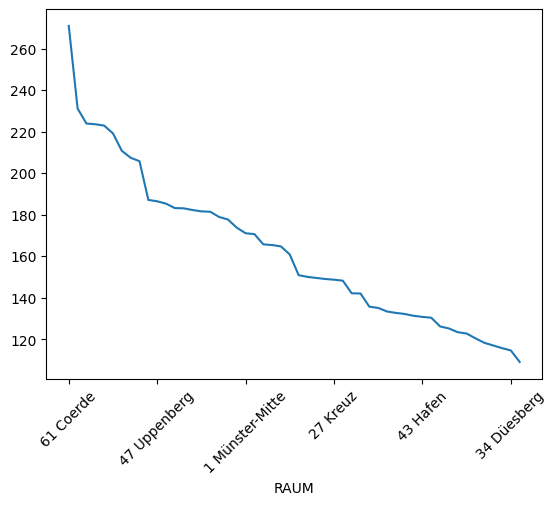

In [320]:
#Anteil der Kinder in alleinerziehende Haushalten
sum_WERT3=df3.groupby("RAUM")['WERT'].sum()
sum_WERT3=sum_WERT3.sort_values(ascending = False)
print(sum_WERT3)

sum_WERT3.plot()
plt.xticks(rotation=45)
plt.show()


RAUM
61 Coerde               191.26
91 Berg Fidel           167.15
63 Kinderhaus-West      149.02
6 Münster-Nord          143.92
86 Angelmodde           108.79
62 Kinderhaus-Ost       100.55
96 Hiltrup-Mitte         85.93
9 Münster-Hiltrup        80.45
81 Gremmendorf-West      79.51
47 Uppenberg             74.48
8 Münster-Südost         71.76
97 Hiltrup-West          71.08
58 Nienberge             61.67
32 Geist                 60.99
Münster. Gesamtstadt     59.39
87 Wolbeck               56.79
33 Schützenhof           55.34
57 Roxel                 55.33
77 Handorf               54.99
51 Gievenbeck            53.16
31 Aaseestadt            53.13
22 Josef                 52.38
7 Münster-Ost            50.03
71 Mauritz-Ost           49.29
23 Bahnhof               49.29
5 Münster-West           47.90
98 Amelsbüren            46.41
24 Hansaplatz            45.39
34 Düesberg              43.66
56 Albachten             43.54
76 Gelmer-Dyckburg       42.24
68 Sprakel               41.54
46 

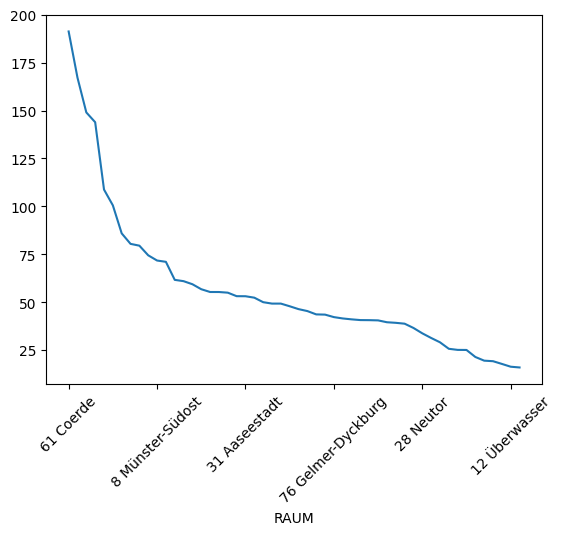

In [321]:
#Anteil der SGBII-Personen im Alter von 15 - 64 Jahren
sum_WERT4=df4.groupby("RAUM")['WERT'].sum()
sum_WERT4=sum_WERT4.sort_values(ascending = False)
print(sum_WERT4)

sum_WERT4.plot()
plt.xticks(rotation=45)
plt.show()

RAUM
61 Coerde               87.58
91 Berg Fidel           75.65
63 Kinderhaus-West      68.93
6 Münster-Nord          67.91
86 Angelmodde           58.08
62 Kinderhaus-Ost       49.66
96 Hiltrup-Mitte        47.62
81 Gremmendorf-West     44.65
9 Münster-Hiltrup       42.87
8 Münster-Südost        41.05
47 Uppenberg            40.69
58 Nienberge            39.35
97 Hiltrup-West         38.34
22 Josef                36.16
23 Bahnhof              35.26
Münster. Gesamtstadt    34.41
33 Schützenhof          34.40
32 Geist                34.21
87 Wolbeck              34.09
77 Handorf              33.61
57 Roxel                32.66
7 Münster-Ost           32.02
24 Hansaplatz           31.36
71 Mauritz-Ost          31.25
76 Gelmer-Dyckburg      31.06
31 Aaseestadt           30.42
68 Sprakel              29.45
34 Düesberg             29.29
95 Hiltrup-Ost          28.42
51 Gievenbeck           28.34
5 Münster-West          28.25
44 Herz-Jesu            27.73
43 Hafen                27.43
1 Mün

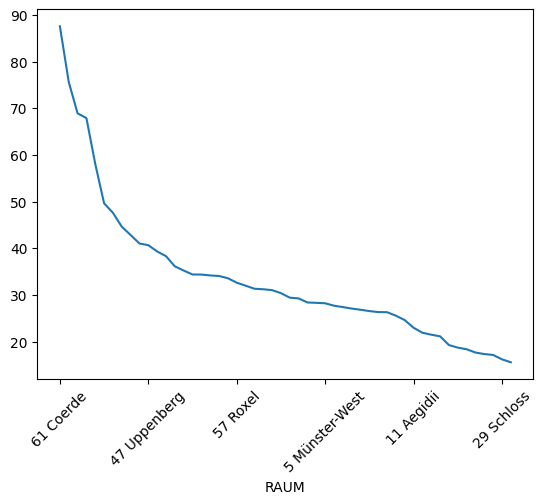

In [322]:
#Anteil der Arbeitslosen(SGB II UND SGB III)
sum_WERT5=df5.groupby("RAUM")['WERT'].sum()
sum_WERT5=sum_WERT5.sort_values(ascending = False)
print(sum_WERT5)

sum_WERT5.plot()
plt.xticks(rotation=45)
plt.show()

Bisher haben wir den Fokus auf die Merkmale für den Gesamtzeitraum 2014-2022 angeschaut. Nun schauen wir uns fest ausgewähle Merkmale im Zeitverlauf an, und schauen uns an wie sich die Prozentzahlen für den Zeitraum entwickelt haben, für ausgewählte Stadtbezirke. Wir fangen mit der Migration an und vergleichen die Enntwicklung in Coerde mit der Entwicklung zB in Gievenbeck. Gievenbeck und Kinderhaus-Ost liegen ca mittig zwischen Coerde und Kreuz.

In [323]:
#Migration in Coerde, Kinderhaus-West, Kinderhaus-Ost, Gievenbeck, Kreuz 2017-2022
df1_COERDE=df1[df1['RAUM']=='61 Coerde']
df1_MigCoerde=df1_COERDE.sort_values(by='ZEIT', ascending=False)
df1_KIWE=df1[df1['RAUM']=='63 Kinderhaus-West']
df1_MigKIWE=df1_KIWE.sort_values(by='ZEIT', ascending=False)
df1_KIOST=df1[df1['RAUM']=='62 Kinderhaus-Ost']
df1_MigKIOST=df1_KIOST.sort_values(by='ZEIT', ascending=False)
df1_GIEVENBECK=df1[df1['RAUM']=='51 Gievenbeck']
df1_MigGIEVENBECK=df1_GIEVENBECK.sort_values(by='ZEIT', ascending=False)
df1_KREUZ=df1[df1['RAUM']=='27 Kreuz']
df1_MigKREUZ=df1_KREUZ.sort_values(by='ZEIT', ascending=False)

#Alles zusammenfügen
df1_COMPARE=pd.concat([df1_MigCoerde,df1_MigKIWE,df1_MigKIOST,df1_MigGIEVENBECK,df1_MigKREUZ], ignore_index=True)
df1_COMPARE

,ZEIT,RAUM,MERKMAL,WERT
0,2022,61 Coerde,Anteil der Kinder mit Migrationsvorgeschichte ...,68.59
1,2021,61 Coerde,Anteil der Kinder mit Migrationsvorgeschichte ...,68.41
2,2020,61 Coerde,Anteil der Kinder mit Migrationsvorgeschichte ...,68.52
3,2019,61 Coerde,Anteil der Kinder mit Migrationsvorgeschichte ...,69.42
4,2018,61 Coerde,Anteil der Kinder mit Migrationsvorgeschichte ...,68.62
5,2017,61 Coerde,Anteil der Kinder mit Migrationsvorgeschichte ...,68.19
6,2016,61 Coerde,Anteil der Kinder mit Migrationsvorgeschichte ...,68.00
7,2015,61 Coerde,Anteil der Kinder mit Migrationsvorgeschichte ...,66.91
8,2014,61 Coerde,Anteil der Kinder mit Migrationsvorgeschichte ...,65.77
9,2022,63 Kinderhaus-West,Anteil der Kinder mit Migrationsvorgeschichte ...,61.12


Wir sehen dass in allen Bezirken die Anteile tendenziell mit den Jahren ansteigen, auch im Kreuzviertel, was einen höheren Sozialindex hat und in der Tabelle im unteren Bereich ist.

In [324]:
#Migration nur im Jahre 2022, über alle Stadtteile (oben hatten wir den ANteil Migration für den Zeitraum 2014-2022 angesehen)
df1_2022=df1[df1['ZEIT']==2022]
df1_2022.sort_values(by='WERT', ascending=False)

,ZEIT,RAUM,MERKMAL,WERT
6,2022,91 Berg Fidel,Anteil der Kinder mit Migrationsvorgeschichte ...,73.98
37,2022,61 Coerde,Anteil der Kinder mit Migrationsvorgeschichte ...,68.59
65,2022,23 Bahnhof,Anteil der Kinder mit Migrationsvorgeschichte ...,62.24
73,2022,63 Kinderhaus-West,Anteil der Kinder mit Migrationsvorgeschichte ...,61.12
93,2022,6 Münster-Nord,Anteil der Kinder mit Migrationsvorgeschichte ...,59.27
113,2022,28 Neutor,Anteil der Kinder mit Migrationsvorgeschichte ...,57.97
178,2022,86 Angelmodde,Anteil der Kinder mit Migrationsvorgeschichte ...,50.83
191,2022,81 Gremmendorf-West,Anteil der Kinder mit Migrationsvorgeschichte ...,49.77
194,2022,12 Überwasser,Anteil der Kinder mit Migrationsvorgeschichte ...,49.23
218,2022,33 Schützenhof,Anteil der Kinder mit Migrationsvorgeschichte ...,47.37


In [325]:
#Anteil der Arbeitslosen(SGB II UND SGB III) 2014-2022
df5_KIWE=df5[df5['RAUM']=='63 Kinderhaus-West']
df5_ALKIWE=df5_KIWE.sort_values(by='ZEIT', ascending=False)
df5_KIOST=df5[df5['RAUM']=='62 Kinderhaus-Ost']
df5_ALKIOST=df5_KIOST.sort_values(by='ZEIT', ascending=False)
df5_COERDE=df5[df5['RAUM']=='61 Coerde']
df5_ALCoerde=df5_COERDE.sort_values(by='ZEIT', ascending=False)
df5_GIEVENBECK=df5[df5['RAUM']=='51 Gievenbeck']
df5_ALGIEVENBECK=df5_GIEVENBECK.sort_values(by='ZEIT', ascending=False)
df5_KREUZ=df5[df5['RAUM']=='27 Kreuz']
df5_ALKREUZ=df5_KREUZ.sort_values(by='ZEIT', ascending=False)
df5_COMPARE=pd.concat([df5_ALCoerde,df5_ALKIWE,df5_ALKIOST,df5_ALGIEVENBECK,df5_ALKREUZ], ignore_index=True)
df5_COMPARE

,ZEIT,RAUM,MERKMAL,WERT
0,2022,61 Coerde,Anteil der Arbeitslosen(SGB II UND SGB III) an...,8.55
1,2021,61 Coerde,Anteil der Arbeitslosen(SGB II UND SGB III) an...,8.20
2,2020,61 Coerde,Anteil der Arbeitslosen(SGB II UND SGB III) an...,9.94
3,2019,61 Coerde,Anteil der Arbeitslosen(SGB II UND SGB III) an...,9.47
4,2018,61 Coerde,Anteil der Arbeitslosen(SGB II UND SGB III) an...,9.83
5,2017,61 Coerde,Anteil der Arbeitslosen(SGB II UND SGB III) an...,9.73
6,2016,61 Coerde,Anteil der Arbeitslosen(SGB II UND SGB III) an...,10.55
7,2015,61 Coerde,Anteil der Arbeitslosen(SGB II UND SGB III) an...,11.04
8,2014,61 Coerde,Anteil der Arbeitslosen(SGB II UND SGB III) an...,10.27
9,2022,63 Kinderhaus-West,Anteil der Arbeitslosen(SGB II UND SGB III) an...,7.46


Erfreulicherweise hat der Arbeitslosenanteil in Coerde im Zeitverlauf tendenziell abgenommen. Im Vergleich ist der Anteil in den anderen Stadtgebieten im Zeitverlauf relativ gleich geblieben.